## Time Series Analysis and Forecasting

### Background and Problem Statement

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the number of taxi orders for the next hour. 


### Metric of Success

A model that predicts the number of taxi orders for the next hour with a  RMSE not be more than 48

### Solution Steps

1. Import libraries
2. Load and explore data
3. Data analysis 
4. Data preparation
5. Modelling: we'll train different models
6. Evaluation
7. Summary of findings & recommendations
8. Challenging the solution

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load and Explore Data

#### Load and preview data

In [2]:
df = pd.read_csv('https://bit.ly/3p1QPAv',  parse_dates=[0])

In [3]:
df.head(3)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28


#### Check the shape

In [4]:
df.shape

(26496, 2)

#### Dataframe summary

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


#### Set dataframe index equal to the Datetime column

In [6]:
df.set_index('datetime', inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Observation**:  our data ranges from March 1st 2018 to August 31st 2018

#### Check whether the dates and times are in chronological order

In [8]:
df.sort_index(inplace=True)
print(df.index.is_monotonic)

True


**Observation**: our data is chronological

## Data Analysis


#### Resampling

Resample by 1 hour and plot

In [9]:
data = df.resample('1H').sum()

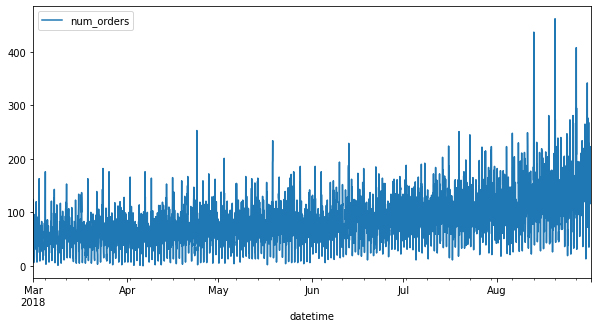

In [10]:
data.plot(figsize=(10, 5))

That's quite crowded, let's resample by 1 day

In [11]:
df_1d = df.resample('1D').sum()

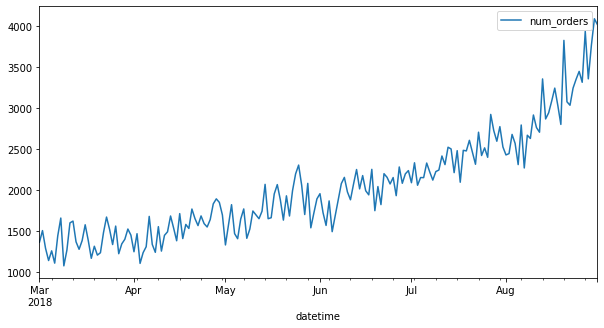

In [12]:
df_1d.plot(figsize=(10, 5))

**Observation**: the number of orders appears to be increasing from March to August

#### Rolling Mean

In [13]:
df_1d['rolling_mean'] = df_1d.rolling(3).mean()

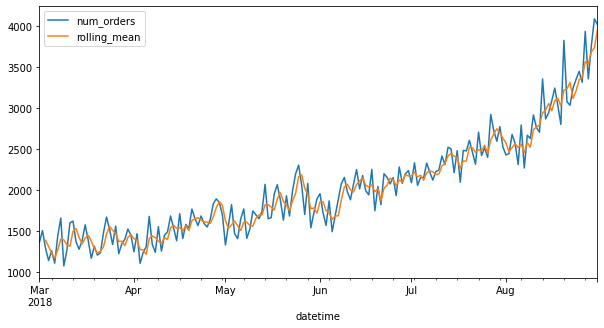

In [14]:
df_1d.plot(figsize=(10, 5))

The rolling mean has a trend similar to the actual number of orders

#### Trends and Seasonality

Seasonal component for the first week of March 2018

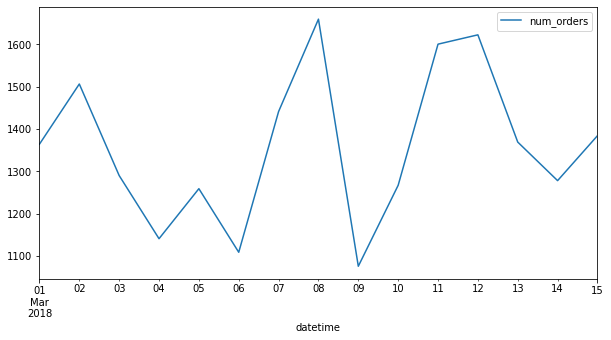

In [15]:
df_15  = df['2018-03-01':'2018-03-15'].resample('1D').sum()

df_15.plot(figsize=(10, 5))

Seasonal component for all data

In [16]:
df_all = df['2018-03':'2018-08'].resample('1D').sum()
decomposed = seasonal_decompose(df_all) 

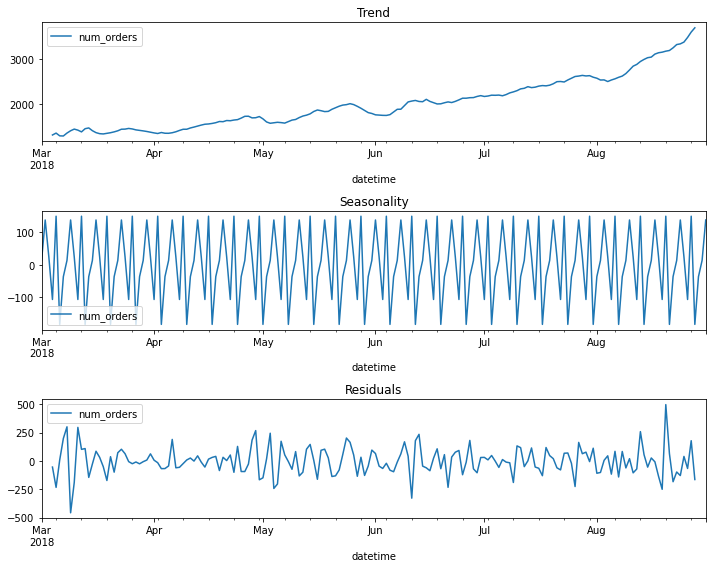

In [17]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout();

#### Time Series Differences

Calculate the time series differences

In [18]:
df_all -= df_all.shift()
df_all['mean'] = df_all['num_orders'].rolling(15).mean()
df_all['std'] = df_all['num_orders'].rolling(15).std()

Plot the rolling mean and rolling standard deviation

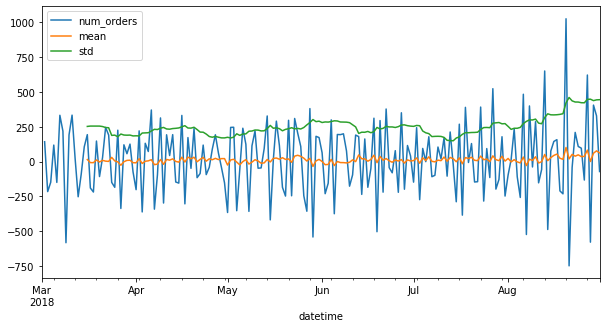

In [19]:
df_all.plot(figsize=(10, 5))

## Data Preparation

#### Create features

In [20]:
def create_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['num_prev_hour'] = data['num_orders'].shift(1)
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean()

In [21]:
create_features(data, 3, 2)
data.head()

,num_orders,year,month,day,dayofweek,num_prev_hour,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,104.5
2018-03-01 02:00:00,71,2018,3,1,3,85.0,78.0
2018-03-01 03:00:00,66,2018,3,1,3,71.0,68.5
2018-03-01 04:00:00,43,2018,3,1,3,66.0,54.5


#### Split data

In [22]:
data.dropna(axis=0, inplace=True)

In [23]:
train, test = train_test_split(data, shuffle=False, train_size=0.9)

Print the minimum and maximum values of the set indices to ensure that the split is done correctly

In [24]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 01:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


**Observation**: the data was broken down correctly: the training set ends on August 13, 2018 at 1 PM, and the test begins on August 13, 2018 at 2 PM.

Predict the number of orders per hour using a constant and find the Mean Absolute Error value for this prediction

In [25]:
pred_median = np.ones(test.shape) * train['num_orders'].median()
print('Median number of orders:', test['num_orders'].median())
print('Mean Absolute Error:', mean_absolute_error(test, pred_median))

Median number of orders: 135.0
Mean Absolute Error: 335.0042016806723


Predict the number of orders per hour using the previous value in the series and find the MAE value for this prediction

In [26]:
print('Median number of orders per hour:', test['num_orders'].median())
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('Mean Absolute Error:', mean_absolute_error(test, pred_previous))

Median number of orders per hour: 135.0
Mean Absolute Error: 16.84146735617324


Set the targets and labels

In [27]:
train_labels = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_labels = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

## Modelling

Initialize models

In [28]:
lg = LinearRegression()
tree = DecisionTreeRegressor()
rf = RandomForestRegressor()
knn = KNeighborsRegressor()
svm = SVR()

Fit models

In [29]:
lg.fit(train_labels, train_target)
tree.fit(train_labels, train_target)
rf.fit(train_labels, train_target)
knn.fit(train_labels, train_target)
svm.fit(train_labels, train_target)

SVR()

Predict

In [30]:
lg_train_pred = lg.predict(train_labels)
lg_test_pred = lg.predict(test_labels)

tree_train_pred = tree.predict(train_labels)
tree_test_pred = tree.predict(test_labels)

rf_train_pred = rf.predict(train_labels)
rf_test_pred = rf.predict(test_labels)

knn_train_pred = knn.predict(train_labels)
knn_test_pred = knn.predict(test_labels)

svm_train_pred = svm.predict(train_labels)
svm_test_pred = svm.predict(test_labels)

## Evaluation

MAE for training and test sets

In [31]:
print("Linear regressor MAE for the training set:", mean_absolute_error(train_target, lg_train_pred))
print("Logistic Regressor MAE for the test set: ", mean_absolute_error(test_target, lg_test_pred))
print()
print("Decision tree regressor MAE for the training set:", mean_absolute_error(train_target, tree_train_pred))
print("Decision tree regressor MAE for the test set: ", mean_absolute_error(test_target, tree_test_pred))
print()
print("Randon forest regressor MAE for the training set:", mean_absolute_error(train_target, rf_train_pred))
print("Randon forest regressor MAE for the test set: ", mean_absolute_error(test_target, rf_test_pred))
print()
print("KNN MAE for the training set:", mean_absolute_error(train_target, knn_train_pred))
print("KNN MAE for the test set: ", mean_absolute_error(test_target, knn_test_pred))
print()
print("SVM MAE for the training set:", mean_absolute_error(train_target, svm_train_pred))
print("SVM MAE for the test set: ", mean_absolute_error(test_target, svm_test_pred))

Linear regressor MAE for the training set: 3.0927006070313214e-14
Logistic Regressor MAE for the test set:  5.545689598842547e-14

Decision tree regressor MAE for the training set: 0.0
Decision tree regressor MAE for the test set:  9.626696832579185

Randon forest regressor MAE for the training set: 0.44762144475207666
Randon forest regressor MAE for the test set:  7.699004524886877

KNN MAE for the training set: 1.9785552479234836
KNN MAE for the test set:  8.505429864253394

SVM MAE for the training set: 27.875209690127324
SVM MAE for the test set:  65.22977088664719


RMSE

In [32]:
print('Linear regressor RMSE:', np.sqrt(mean_squared_error(test_target, lg_test_pred)))
print('Decision tree regressor RMSE:', np.sqrt(mean_squared_error(test_target, tree_test_pred)))
print('Randon forest regressor RMSE:', np.sqrt(mean_squared_error(test_target, rf_test_pred)))
print('KNN RMSE:', np.sqrt(mean_squared_error(test_target, knn_test_pred)))
print('SVM RMSE:', np.sqrt(mean_squared_error(test_target, svm_test_pred)))

Linear regressor RMSE: 7.568832255863795e-14
Decision tree regressor RMSE: 21.623317814414314
Randon forest regressor RMSE: 19.78870171043607
KNN RMSE: 19.6097099412995
SVM RMSE: 80.78092335299533


## Summary of findings and Recommendations

Linear regression model was the best model. I would recommend it to Sweet Lift Taxi company to predict the number of taxi orders for subsequent hours.

## Challenging the solution

Did we have the right question?
Yes

Did we have the right data?
Yes

What can be done to improve the solution? Hyperparameter tuning
